## Setting

On présente une implémentation en tensorflow du modèle FNO (Fourier Neural Operator) venant de [cet article](https://openreview.net/pdf?id=c8P9NQVtmnO)

On y a apporté quelques modifications (d'où le nom FNO1D_plus)

Le très grands avantage d'un FNO est qui est qu'on peut l'entrainée avec des données calculée sur des grilles de résolutions variée et l'utiliser sur des grilles de résolution différente. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%reset -f
#%cd /content/drive/MyDrive/ML_Burgers/

Mounted at /content/drive


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
%cd /content/drive/Othercomputers/Mon MacBook Pro/google_saved/PYTHON/small_libs
%ls

/content/drive/Othercomputers/Mon MacBook Pro/google_saved/PYTHON/small_libs
consecutive_windows/      paddings/   preference_sampling/
derivator/                popup_lib/
fourier_neural_operator/  poubel/


In [4]:
import fourier_neural_operator.FNO_1d_plus as fno
import fourier_neural_operator.test_env as te

In [31]:
pp=print
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Définition du modèle

Voici la signature du modèle

        FNO1d_plus( 
            modes:int, 
            width:int,
            out_channels:int,
            nb_layer=4,
            first_channel_unchanged=False,
            freq_mix_size=0,
            pad_prop=0.1,
            pad_kind="zero_padding",
            verbose=False)

* mode: nombre de coefficients de fourier gardés
* width: dimension de travail des layers
* out_channels: dimension de sortie
* nb_layer=4: le nombre de layers
* first_channel_unchanged=True Si l'on veut garder les fréquences inchangée dans le premier channel, à l'initialisation des poids (sorte de res-net fréquentiel)
* pad_prop: le padding des entrée est de taille pad_prop*len(signal) de chaque côtés
* pad_kind: type de padding (cf. ci-dessous)
* freq_mix_size: des convolutions de tailles freq_mix_size sont appliquées au fréquences


Les paddings sont à choisir dans la liste suivante:

In [43]:
import paddings.paddings as pad

In [45]:
pad.kind_dict.keys()

dict_keys(['zero_padding', 'dirichlet_padding', 'smooth_padding', 'periodic_padding', 'smooth_periodizing_padding', 'linear_periodizing_padding'])

Ce qui correspond aux prolongements suivants:

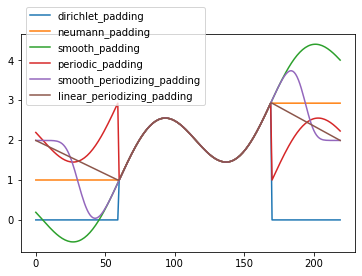

In [46]:
pad.test_pad_1d()

In [28]:
model = fno.FNO1d_plus(mode=20, width=15,out_channels=1,first_channel_unchanged=False,pad_prop=0.1,pad_kind="zero_padding",freq_mix_size=0,verbose=True)

modèle FNO1d crée avec comme hyperparamètre: modes:20, width:15,level:4, pad_prop:0.1 


## Un FNO peut apprendre à dériver

On demande au modèle de faire le lien entre une fonction et sa dérivée:

Input:

        x-> tf.sin(nu * 2 * np.pi * x ** 2)

Output:

        x-> nu * tf.cos(nu * 2 * np.pi * x ** 2) * 2 * x


pour différents `nu`



In [25]:
data_creator_train=te.DataCreator1D(nx=80,batch_size=64)

In [36]:
def train(model):
    optimizer=tf.keras.optimizers.Adam()
    losses=[]
    try:
        for i in range(1000):
            X,Y=data_creator_train.call()

            with tf.GradientTape() as tape:
                Y_pred=model.call(X)
                loss=data_creator_train.loss(Y,Y_pred)

            grad=tape.gradient(loss,model.trainable_variables)
            optimizer.apply_gradients(zip(grad,model.trainable_variables))
            losses.append(loss.numpy())

            if i%50==0:
                print(f"MSE train error at step:{i}: {loss.numpy()}",)
    except KeyboardInterrupt:
        pass

    fig,ax=plt.subplots()
    ax.plot(losses)
    ax.set_title("train loss")
    ax.set_yscale("log")

MSE train error at step:0: 0.0013413664419203997
MSE train error at step:50: 0.0023177284747362137
MSE train error at step:100: 0.001938655972480774
MSE train error at step:150: 0.0019062977517023683
MSE train error at step:200: 0.0011704076314345002
MSE train error at step:250: 0.001050727441906929
MSE train error at step:300: 0.0013832205440849066
MSE train error at step:350: 0.0006704826955683529
MSE train error at step:400: 0.0007039261981844902
MSE train error at step:450: 0.0007021196652203798
MSE train error at step:500: 0.0006728146690875292
MSE train error at step:550: 0.0006804423173889518
MSE train error at step:600: 0.0006230034050531685
MSE train error at step:650: 0.0011687648948282003
MSE train error at step:700: 0.0007959884824231267
MSE train error at step:750: 0.0005014838534407318
MSE train error at step:800: 0.00033927796175703406
MSE train error at step:850: 0.00033115115365944803
MSE train error at step:900: 0.00028554629534482956
MSE train error at step:950: 0.00

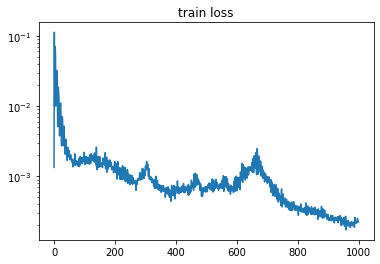

In [37]:
losses=train(model)

## Test dans la résolution de l'entrainement

In [32]:
def display_results(data_creator:te.DataCreator1D,model):

    nb=8# <= data_creator.batch_size
    fig,axs=plt.subplots(nb,4,sharey="row",sharex="all",figsize=(20,2*nb))
    A,U=data_creator.call()
    U_hat = model.call(A)
    print(f"MSE error with resolution nx:{data_creator.nx}:",data_creator.loss(U,U_hat))
    for i in range(nb):
        error = U[i, :, 0] - U_hat[i, :, 0]
        axs[i,0].plot(A[i,:,0])
        axs[i,1].plot(U[i,:,0])
        axs[i,2].plot(U_hat[i,:,0])
        axs[i,3].plot(error)

    axs[0,0].set_title("input")
    axs[0,1].set_title("output")
    axs[0,2].set_title("prediction")
    axs[0,3].set_title("error")

    plt.show()


MSE error with resolution nx:80: tf.Tensor(0.00023996914, shape=(), dtype=float32)


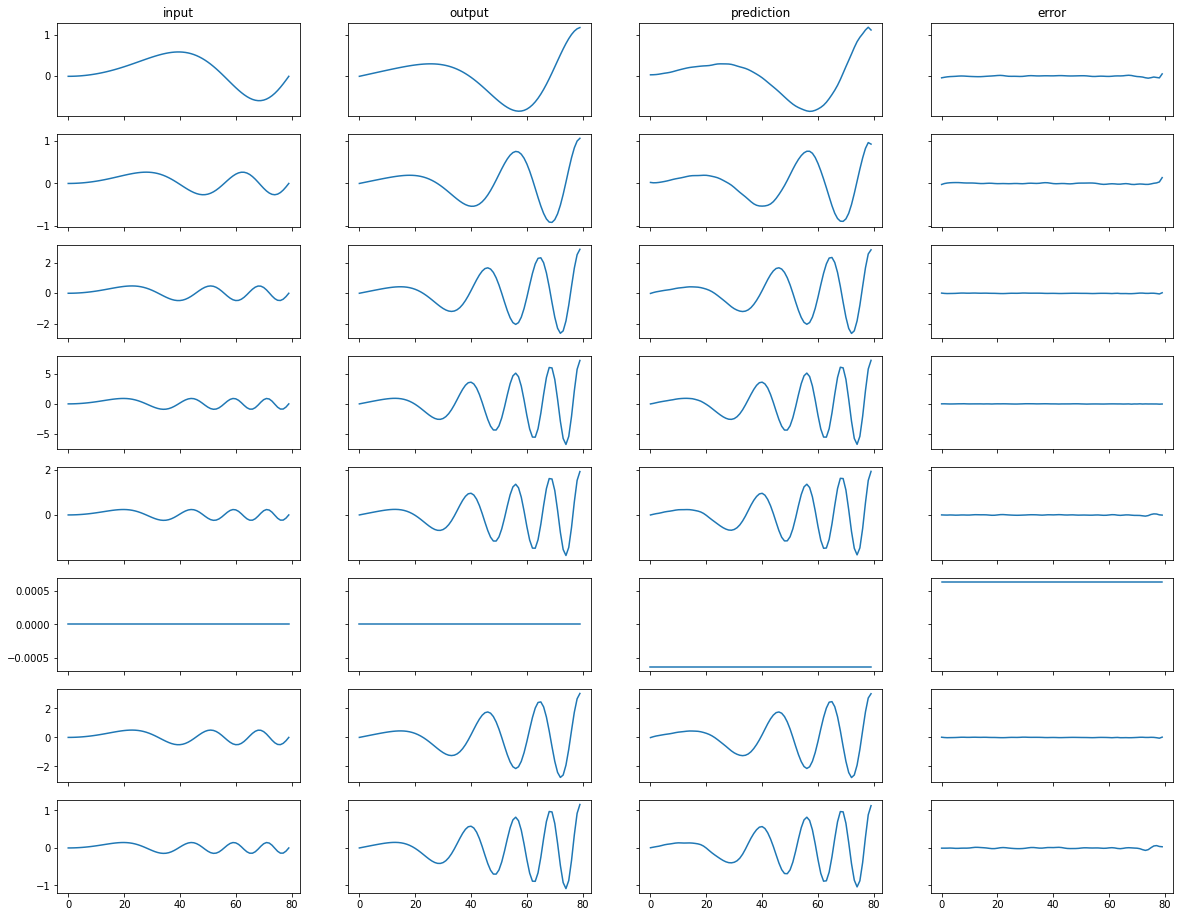

In [39]:
display_results(data_creator_train,model)

## Test avec résolution supèrieure

traçage de la méthode call de FNO1d_plus, pad=15
MSE error with resolution nx:150: tf.Tensor(0.00090276566, shape=(), dtype=float32)


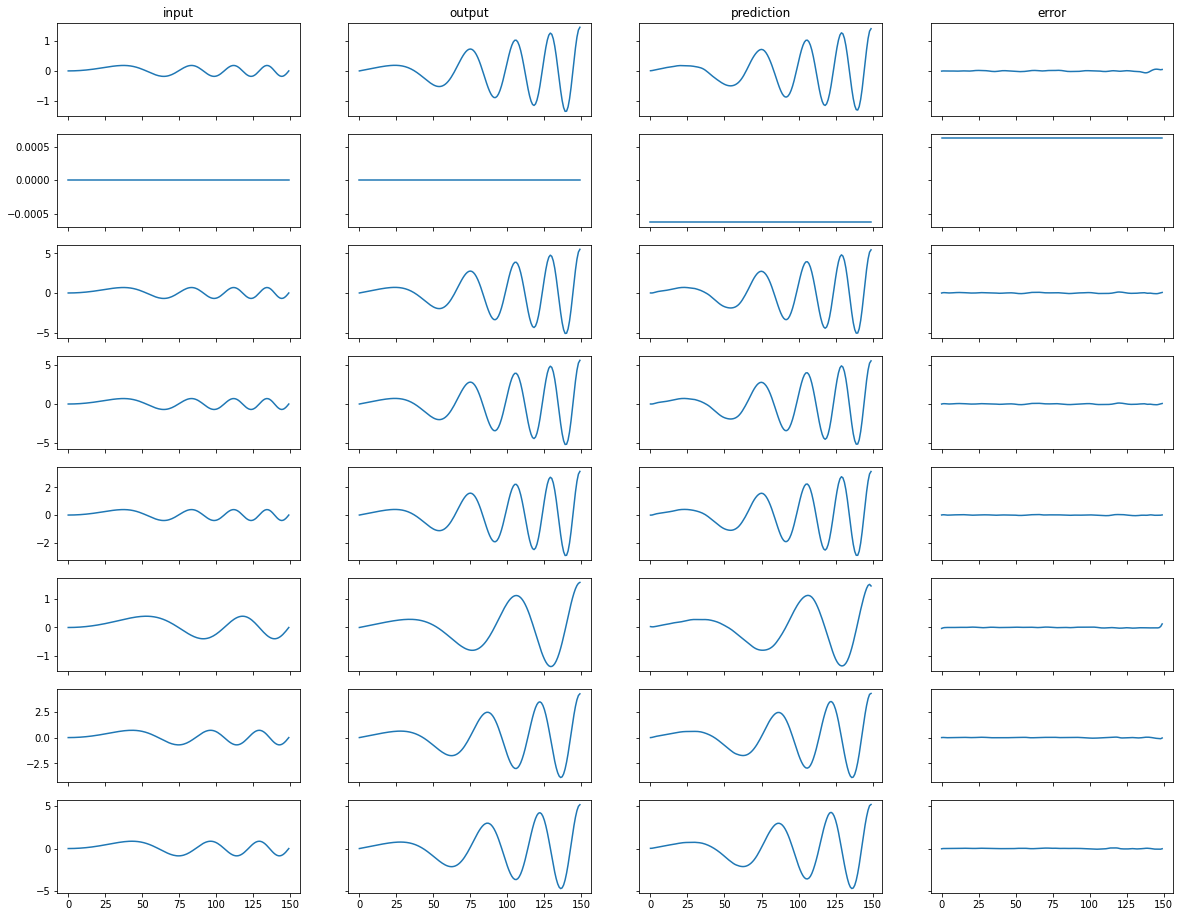

In [41]:
data_creator_test=te.DataCreator1D(150,64)
display_results(data_creator_test,model)

## Test avec résolution inférieure

traçage de la méthode call de FNO1d_plus, pad=5
MSE error with resolution nx:50: tf.Tensor(0.0010809257, shape=(), dtype=float32)


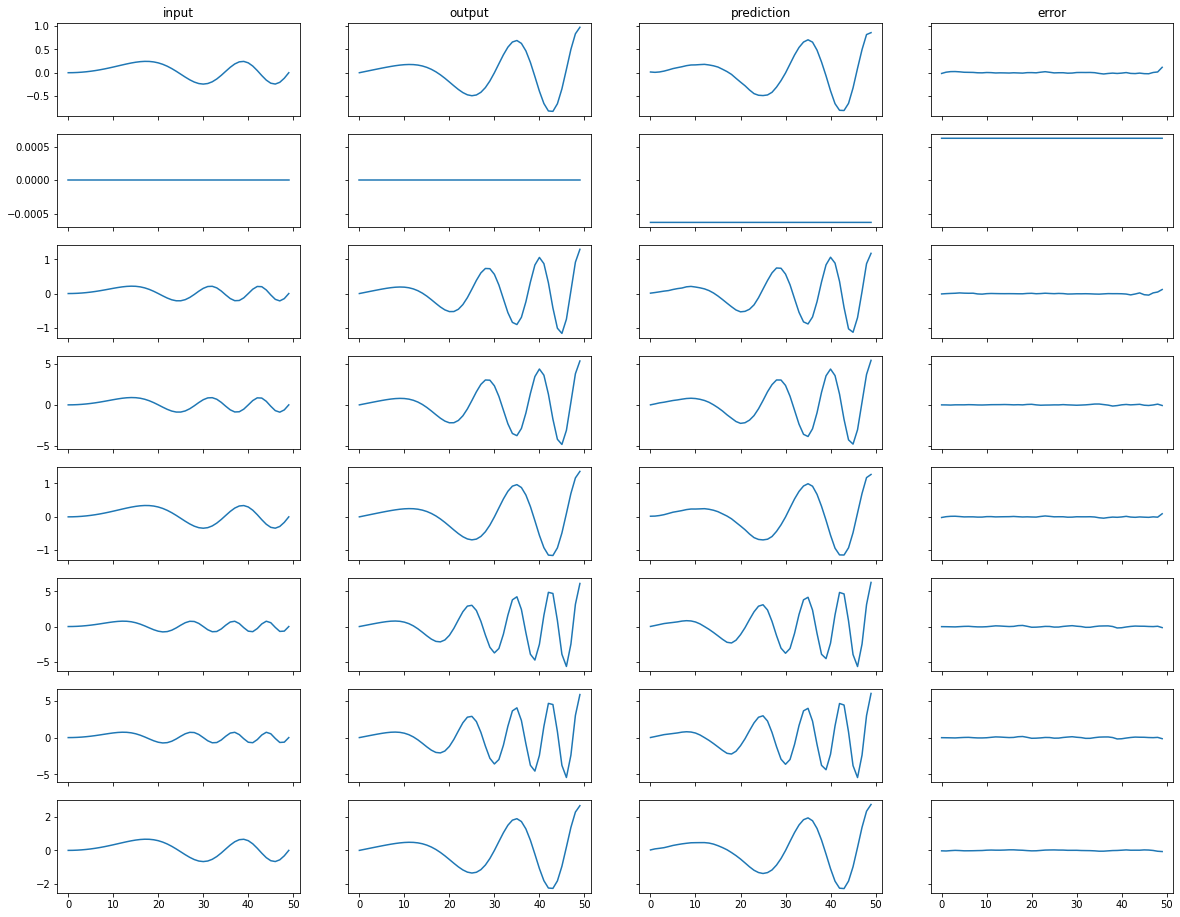

In [42]:
data_creator_test=te.DataCreator1D(50,64)
display_results(data_creator_test,model)

## test d'hyper paramètre

Nous allons faire varier un à un les paramètres du FNO en partant de la configuration suivante:

In [20]:
te.default_param()

{'first_channel_unchanged': False,
 'freq_mix_size': 0,
 'pad_kind': 'zero_padding',
 'pad_prop': 0.1}

test les pad_kind dans:['no_padding', 'zero_padding', 'dirichlet_padding', 'smooth_padding', 'periodic_padding', 'smooth_periodizing_padding', 'linear_periodizing_padding']
key=pad_kind, val=no_padding
↘7.2e-01↘6.5e-01↘5.2e-01↘5.2e-01↘4.5e-01↘4.1e-01↘3.5e-01↘3.5e-01↘3.3e-01↘3.0e-01↘2.6e-01↘1.8e-01↘1.7e-01↘1.5e-01↘1.4e-01↘1.1e-01↘1.0e-01↘8.8e-02↘8.8e-02↘8.2e-02↘6.9e-02↘6.5e-02↘5.6e-02↘4.7e-02↘4.3e-02↘4.1e-02↘4.0e-02↘3.5e-02↘3.3e-02↘3.2e-02↘3.0e-02↘2.8e-02↘2.4e-02↘2.3e-02↘2.0e-02↘1.9e-02↘1.9e-02↘1.7e-02↘1.6e-02↘1.5e-02↘1.4e-02↘1.2e-02↘1.2e-02↘1.1e-02↘1.1e-02↘1.1e-02↘1.1e-02↘9.8e-03↘8.9e-03↘7.8e-03↘7.1e-03↘7.1e-03↘5.8e-03↘5.7e-03↘5.5e-03↘5.3e-03↘5.1e-03↘5.1e-03↘4.6e-03↘4.5e-03↘4.0e-03↘3.9e-03↘3.6e-03↘3.6e-03↘3.3e-03↘3.2e-03↘3.1e-03↘2.8e-03↘2.8e-03↘2.5e-03↘2.4e-03↘2.4e-03↘2.3e-03↘2.3e-03↘2.1e-03↘2.0e-03↘2.0e-03↘2.0e-03↘1.9e-03↘1.8e-03↘1.7e-03↘1.7e-03↘1.5e-03↘1.5e-03↘1.4e-03↘1.4e-03↘1.2e-03↘1.2e-03↘1.2e-03↘1.2e-03↘1.0e-03↘1.0e-03↘1.0e-03↘1.0e-03↘9.3e-04↘8.6e-04↘8.3e-04↘8.2e-04↘7.0e-04↘6.3e-

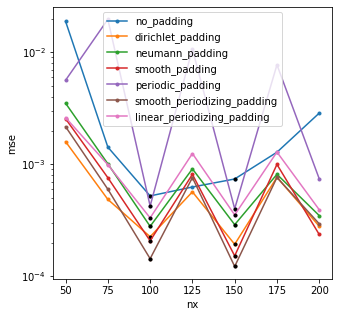

In [16]:
te.test_changing_pad_kind()

test les pad_prop dans:[0, 0.02, 0.05, 0.1, 0.2]
key=pad_prop, val=0
↘8.1e-01↘7.7e-01↘5.9e-01↘5.0e-01↘4.8e-01↘3.9e-01↘3.9e-01↘3.8e-01↘3.6e-01↘3.6e-01↘3.3e-01↘2.8e-01↘2.7e-01↘2.4e-01↘2.4e-01↘2.1e-01↘1.9e-01↘1.5e-01↘1.4e-01↘1.4e-01↘1.2e-01↘1.1e-01↘1.0e-01↘7.8e-02↘7.6e-02↘7.3e-02↘5.5e-02↘5.3e-02↘4.8e-02↘4.6e-02↘4.5e-02↘3.6e-02↘3.5e-02↘3.0e-02↘2.9e-02↘2.8e-02↘2.7e-02↘2.1e-02↘2.0e-02↘1.9e-02↘1.9e-02↘1.8e-02↘1.8e-02↘1.7e-02↘1.7e-02↘1.4e-02↘1.3e-02↘1.2e-02↘1.2e-02↘1.2e-02↘1.1e-02↘1.1e-02↘1.1e-02↘1.1e-02↘1.0e-02↘8.6e-03↘8.5e-03↘8.2e-03↘8.1e-03↘7.6e-03↘7.5e-03↘7.3e-03↘7.3e-03↘6.9e-03↘6.1e-03↘5.5e-03↘5.4e-03↘4.6e-03↘4.5e-03↘4.0e-03↘3.9e-03↘3.4e-03
 nb epochs:315 during 1 minutes
losses_test [0.022330826, 0.008157259, 0.006237168, 0.007278411, 0.009974671, 0.008935775, 0.011285844]
key=pad_prop, val=0.02
↘8.0e-01↘7.2e-01↘6.9e-01↘6.3e-01↘5.0e-01↘3.8e-01↘3.5e-01↘3.4e-01↘2.6e-01↘2.3e-01↘2.2e-01↘1.7e-01↘1.7e-01↘1.5e-01↘1.2e-01↘1.1e-01↘1.1e-01↘1.0e-01↘7.4e-02↘5.5e-02↘5.0e-02↘4.0e-02↘3.5e-02↘3.4e-02↘3.

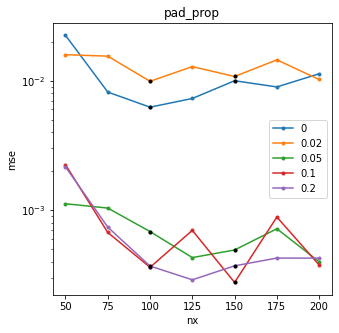

In [17]:
te.test_changing_pad_prop()

test les freq_mix_size dans:[0, 3, 5, 7, 9]
key=freq_mix_size, val=0
↘8.5e-01↘7.2e-01↘5.1e-01↘4.9e-01↘4.7e-01↘3.8e-01↘3.6e-01↘2.7e-01↘1.8e-01↘1.5e-01↘1.4e-01↘1.1e-01↘1.1e-01↘1.1e-01↘7.2e-02↘6.5e-02↘6.3e-02↘6.0e-02↘5.0e-02↘4.7e-02↘3.9e-02↘3.4e-02↘2.7e-02↘2.1e-02↘1.9e-02↘1.8e-02↘1.8e-02↘1.6e-02↘1.4e-02↘1.3e-02↘1.2e-02↘1.2e-02↘1.0e-02↘9.4e-03↘9.3e-03↘8.7e-03↘8.1e-03↘7.4e-03↘7.2e-03↘7.1e-03↘5.8e-03↘4.3e-03↘4.2e-03↘4.0e-03↘3.6e-03↘3.5e-03↘3.5e-03↘3.5e-03↘3.2e-03↘3.1e-03↘3.1e-03↘3.0e-03↘3.0e-03↘2.7e-03↘2.6e-03↘2.5e-03↘2.4e-03↘2.2e-03↘2.0e-03↘2.0e-03↘1.8e-03↘1.7e-03↘1.7e-03↘1.6e-03↘1.5e-03↘1.4e-03↘1.4e-03↘1.3e-03↘1.3e-03↘1.2e-03↘1.1e-03↘1.1e-03↘1.0e-03↘9.7e-04↘9.5e-04↘9.4e-04↘9.3e-04↘9.1e-04↘8.6e-04↘8.2e-04↘7.9e-04↘7.7e-04↘7.3e-04↘6.6e-04↘5.9e-04↘5.6e-04↘5.2e-04↘4.8e-04↘4.4e-04↘4.2e-04↘4.0e-04↘3.8e-04↘3.6e-04↘3.1e-04↘3.0e-04↘2.7e-04↘2.5e-04↘2.3e-04↘2.1e-04↘2.0e-04↘2.0e-04↘2.0e-04↘1.9e-04↘1.5e-04↘1.5e-04↘1.5e-04↘1.5e-04↘1.4e-04↘1.4e-04↘1.2e-04
 nb epochs:1376 during 1 minutes
losses_test [0.00

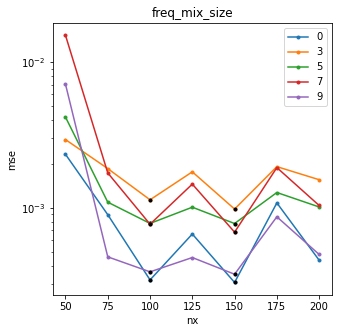

In [18]:
te.test_changing_freq_mix_size()

test les first_channel_unchanged dans:[False, True]
key=first_channel_unchanged, val=False
↘8.7e-01↘8.2e-01↘6.6e-01↘6.1e-01↘5.2e-01↘4.9e-01↘3.2e-01↘3.0e-01↘2.7e-01↘2.6e-01↘2.3e-01↘2.1e-01↘1.4e-01↘1.3e-01↘1.2e-01↘9.2e-02↘7.9e-02↘7.5e-02↘6.5e-02↘6.0e-02↘5.9e-02↘4.5e-02↘3.9e-02↘3.3e-02↘3.3e-02↘2.9e-02↘2.8e-02↘2.7e-02↘2.3e-02↘2.3e-02↘2.0e-02↘1.9e-02↘1.5e-02↘1.5e-02↘1.3e-02↘1.2e-02↘1.2e-02↘1.1e-02↘9.1e-03↘8.3e-03↘7.7e-03↘6.7e-03↘5.8e-03↘5.7e-03↘5.0e-03↘4.5e-03↘4.3e-03↘3.7e-03↘3.3e-03↘2.9e-03↘2.8e-03↘2.6e-03↘2.4e-03↘2.4e-03↘2.3e-03↘2.3e-03↘2.2e-03↘1.9e-03↘1.9e-03↘1.8e-03↘1.4e-03↘1.4e-03↘1.3e-03↘1.3e-03↘1.2e-03↘1.1e-03↘1.0e-03↘9.3e-04↘8.2e-04↘7.9e-04↘7.9e-04↘7.7e-04↘7.5e-04↘7.2e-04↘7.0e-04↘6.6e-04↘6.1e-04↘5.5e-04↘5.3e-04↘5.1e-04↘5.1e-04↘4.9e-04↘4.9e-04↘4.5e-04↘3.7e-04↘3.3e-04↘3.0e-04↘2.7e-04↘2.4e-04↘2.1e-04↘2.1e-04↘2.0e-04↘1.9e-04↘1.6e-04↘1.5e-04↘1.5e-04↘1.4e-04↘1.2e-04↘1.1e-04↘1.0e-04↘8.9e-05↘8.9e-05↘8.2e-05
 nb epochs:1444 during 1 minutes
losses_test [0.0030272987, 0.0006962863, 0.00034788

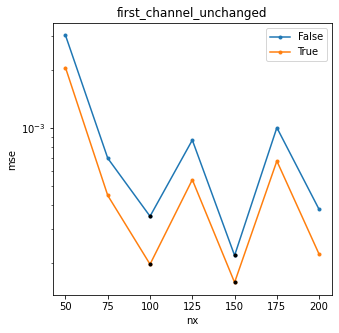

In [21]:
te.test_changing_first_channel_unchanged()

test les mode dans:[5, 10, 15, 20, 24]
key=mode, val=5
↘8.7e-01↘7.9e-01↘7.9e-01↘7.2e-01↘6.2e-01↘5.3e-01↘4.0e-01↘3.9e-01↘3.9e-01↘3.3e-01↘3.1e-01↘2.6e-01↘2.3e-01↘2.2e-01↘2.0e-01↘2.0e-01↘1.7e-01↘1.5e-01
 nb epochs:132 during 1 minutes


losses_test [0.5884546, 0.35854343, 0.5403049, 0.3677724, 0.6549472, 0.3508105, 0.40432715]
key=mode, val=10
↘8.4e-01↘7.4e-01↘6.9e-01↘5.5e-01↘4.5e-01↘3.8e-01↘2.4e-01↘2.3e-01↘2.1e-01↘1.6e-01↘1.4e-01↘1.3e-01↘1.1e-01↘1.0e-01↘9.4e-02↘8.1e-02↘7.3e-02↘7.0e-02↘6.5e-02↘5.4e-02↘5.3e-02↘4.6e-02↘4.0e-02↘3.3e-02↘3.1e-02↘2.5e-02↘2.1e-02↘1.9e-02↘1.7e-02↘1.6e-02↘1.4e-02↘1.3e-02↘1.1e-02↘1.1e-02↘9.7e-03↘9.5e-03↘8.7e-03↘8.6e-03↘8.1e-03↘7.9e-03↘7.6e-03↘6.8e-03↘6.4e-03↘6.2e-03↘5.3e-03↘5.3e-03↘4.2e-03↘4.2e-03↘4.1e-03↘3.8e-03↘3.7e-03↘3.6e-03↘3.3e-03↘3.0e-03↘2.9e-03↘2.9e-03↘2.9e-03↘2.3e-03↘2.2e-03↘2.0e-03↘1.9e-03↘1.8e-03↘1.7e-03↘1.6e-03↘1.6e-03↘1.4e-03↘1.3e-03↘1.3e-03↘1.2e-03↘1.2e-03↘1.2e-03↘1.2e-03↘1.1e-03↘1.0e-03↘1.0e-03↘1.0e-03↘1.0e-03↘9.8e-04↘9.5e-04↘9.3e-04↘9.0e-04↘8.2e-04↘8.1e-04↘7.1e-04↘7.0e-04↘6.8e-04↘6.5e-04↘6.3e-04↘6.3e-04↘5.8e-04↘5.7e-04↘4.9e-04↘4.8e-04↘4.7e-04↘4.2e-04↘4.1e-04↘3.6e-04↘3.4e-04↘3.4e-04↘3.0e-04↘2.6e-04↘2.3e-04
 nb epochs:1429 during 1 minutes
losses_test [0.0028763895, 0.0013073328, 

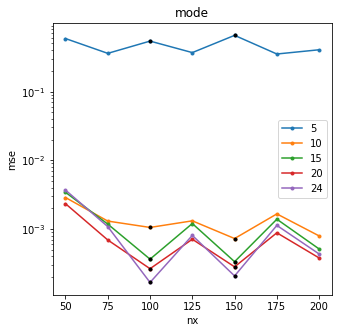

In [22]:
te.test_changing_mode()

test les width dans:[5, 10, 15, 20, 25]
key=width, val=5
↘9.8e-01↘6.6e-01↘6.3e-01↘5.8e-01↘5.0e-01↘3.6e-01↘3.5e-01↘3.4e-01↘2.3e-01↘2.1e-01↘1.7e-01↘1.5e-01↘1.4e-01↘1.3e-01↘1.3e-01↘1.2e-01↘8.2e-02↘7.0e-02↘6.7e-02↘4.0e-02↘3.7e-02↘3.6e-02↘3.4e-02↘2.9e-02↘2.8e-02↘2.2e-02↘2.1e-02↘1.8e-02↘1.7e-02↘1.6e-02↘1.6e-02↘1.5e-02↘1.3e-02↘1.3e-02↘1.3e-02↘1.2e-02↘1.1e-02↘1.0e-02↘9.3e-03↘8.0e-03↘7.7e-03↘7.0e-03↘6.9e-03↘6.5e-03↘6.3e-03↘6.0e-03↘5.4e-03↘5.2e-03↘5.0e-03↘4.8e-03↘4.8e-03↘4.7e-03↘4.6e-03↘4.5e-03↘3.7e-03↘3.7e-03↘3.6e-03↘3.4e-03↘3.2e-03↘3.2e-03↘2.9e-03↘2.9e-03↘2.8e-03↘2.7e-03↘2.6e-03↘2.5e-03↘2.5e-03↘2.3e-03↘1.9e-03↘1.8e-03↘1.6e-03↘1.5e-03↘1.5e-03↘1.3e-03↘1.3e-03↘1.2e-03↘1.2e-03↘1.0e-03↘9.5e-04↘8.5e-04↘8.3e-04↘8.1e-04↘8.0e-04↘7.5e-04↘7.4e-04↘7.1e-04↘6.7e-04↘6.6e-04↘6.5e-04↘6.3e-04↘6.3e-04↘6.1e-04↘5.4e-04↘5.0e-04↘4.6e-04↘4.2e-04
 nb epochs:1420 during 1 minutes
losses_test [0.002365441, 0.0014049367, 0.0011532631, 0.0013194259, 0.0010979605, 0.0015374268, 0.0009677525]
key=width, val=10
↘7.7e-01↘7.1e

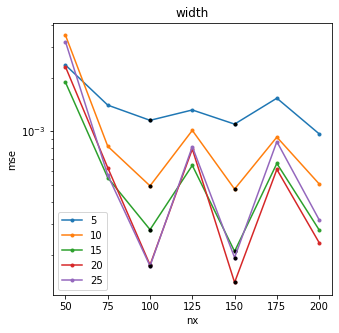

In [24]:
te.test_changing_width()

test les nb_layer dans:[2, 3, 4, 5]
key=nb_layer, val=2
↘7.9e-01↘7.3e-01↘6.5e-01↘6.0e-01↘5.3e-01↘4.7e-01↘4.6e-01↘4.1e-01↘3.9e-01↘3.7e-01↘3.2e-01↘3.0e-01↘2.9e-01↘2.8e-01↘2.8e-01↘2.7e-01↘2.4e-01↘2.2e-01↘2.0e-01↘1.7e-01↘1.4e-01↘1.3e-01↘1.2e-01↘1.1e-01↘1.0e-01↘8.6e-02↘8.0e-02↘7.9e-02↘6.4e-02↘6.3e-02↘5.9e-02↘5.4e-02↘5.4e-02↘5.3e-02↘4.2e-02↘3.3e-02↘2.5e-02↘2.4e-02↘2.3e-02↘2.3e-02↘2.2e-02↘2.2e-02↘2.0e-02↘1.9e-02↘1.8e-02↘1.5e-02↘1.4e-02↘1.3e-02↘1.2e-02↘1.1e-02↘1.1e-02↘1.1e-02↘9.0e-03↘8.4e-03↘7.4e-03↘7.1e-03↘6.7e-03↘6.6e-03↘6.0e-03↘5.9e-03↘5.9e-03↘5.4e-03↘4.3e-03↘3.8e-03↘3.3e-03↘2.9e-03↘2.9e-03↘2.7e-03↘2.6e-03↘2.3e-03↘2.3e-03↘2.3e-03↘2.2e-03↘2.1e-03↘1.9e-03↘1.8e-03↘1.5e-03↘1.4e-03↘1.3e-03↘1.2e-03↘1.2e-03↘1.2e-03↘1.1e-03↘1.1e-03↘1.0e-03↘8.9e-04↘8.4e-04↘7.8e-04↘7.7e-04↘7.6e-04↘7.5e-04↘7.2e-04↘7.1e-04↘6.7e-04↘6.4e-04↘6.1e-04↘5.7e-04↘5.6e-04↘5.5e-04↘5.5e-04↘5.1e-04↘5.0e-04↘4.2e-04↘3.9e-04↘3.7e-04↘3.3e-04↘3.0e-04↘2.8e-04↘2.3e-04↘2.1e-04
 nb epochs:1983 during 1 minutes


losses_test [0.0030976573, 0.00095997343, 0.00074165495, 0.0009849727, 0.0005916838, 0.0013854632, 0.00063665165]
key=nb_layer, val=3
↘1.1e+00↘9.2e-01↘8.3e-01↘7.3e-01↘4.9e-01↘4.5e-01↘3.4e-01↘3.3e-01↘2.8e-01↘2.6e-01↘2.5e-01↘2.1e-01↘2.1e-01↘1.5e-01↘1.4e-01↘1.2e-01↘1.1e-01↘9.5e-02↘8.3e-02↘7.8e-02↘7.0e-02↘6.6e-02↘6.0e-02↘5.4e-02↘4.8e-02↘4.8e-02↘4.2e-02↘4.2e-02↘3.9e-02↘3.4e-02↘3.4e-02↘3.0e-02↘2.7e-02↘2.6e-02↘2.3e-02↘2.3e-02↘2.1e-02↘2.1e-02↘2.0e-02↘1.8e-02↘1.8e-02↘1.6e-02↘1.5e-02↘1.4e-02↘1.4e-02↘1.3e-02↘1.1e-02↘1.1e-02↘1.1e-02↘9.1e-03↘9.0e-03↘8.2e-03↘8.0e-03↘7.8e-03↘7.0e-03↘6.8e-03↘6.6e-03↘5.5e-03↘5.0e-03↘5.0e-03↘4.7e-03↘4.6e-03↘4.3e-03↘3.9e-03↘3.7e-03↘3.5e-03↘3.0e-03↘2.5e-03↘2.3e-03↘2.2e-03↘2.2e-03↘2.1e-03↘2.0e-03↘1.9e-03↘1.9e-03↘1.8e-03↘1.7e-03↘1.7e-03↘1.5e-03↘1.4e-03↘1.4e-03↘1.4e-03↘1.4e-03↘1.3e-03↘1.3e-03↘1.2e-03↘9.7e-04↘8.7e-04↘8.4e-04↘8.4e-04↘8.1e-04↘7.9e-04↘7.4e-04↘6.9e-04↘6.9e-04↘6.5e-04↘6.5e-04↘5.9e-04↘5.8e-04↘5.2e-04↘4.3e-04↘4.2e-04↘3.5e-04↘3.4e-04↘3.3e-04↘3.3e-04↘3.0e-04↘2.8e-04↘2

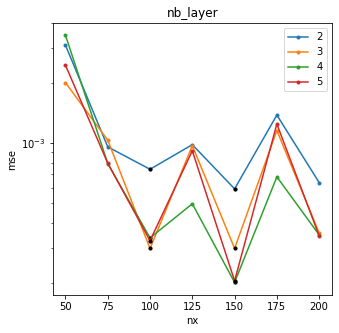

In [49]:
te.test_changing_nb_layer()

## En interne

Le FNO est constitué de `nb_layer` layers effectuant des convolutions par fft. Ils sont enchainé avec des connections résiduelles.

Voici la signature d'un layer. Remarquons qu'un layer peut servir de prétraitement à un autre réseau (ex: Unet). Car il permet d'interpoler (possibilité d'imposer un longueur de signal en sortie avec l'argument `N_out_imposed`). 

        SpectralConv1d_plus(
            in_channels:int, 
            out_channels:int, 
            modes:int,
            first_channel_unchanged:bool,
            N_out_imposed=None,
            freq_mix_size=0):


* in_channels:int dimension d'entrée
* out_channels:int dimension de sortie
* modes:int nombre de fréquences filtrées
* first_channel_unchanged:bool: voir au dessus
* N_out_imposed: si l'on veut que la longueur du signal en sortie soit différente de celle en entrée.
* freq_mix_size=0: voir au dessus


====== Init ======
mesh size:  256
mesh step:  tf.Tensor(0.003921569, shape=(), dtype=float32)
bc type  :  Neumann
traçage de la fonction generate_XY
duration=0.0017218589782714844 for nb_data=1500 with nb points=256
X_train (1500, 256, 2) <dtype: 'float32'>
Y_train (1500, 256, 1) <dtype: 'float32'>


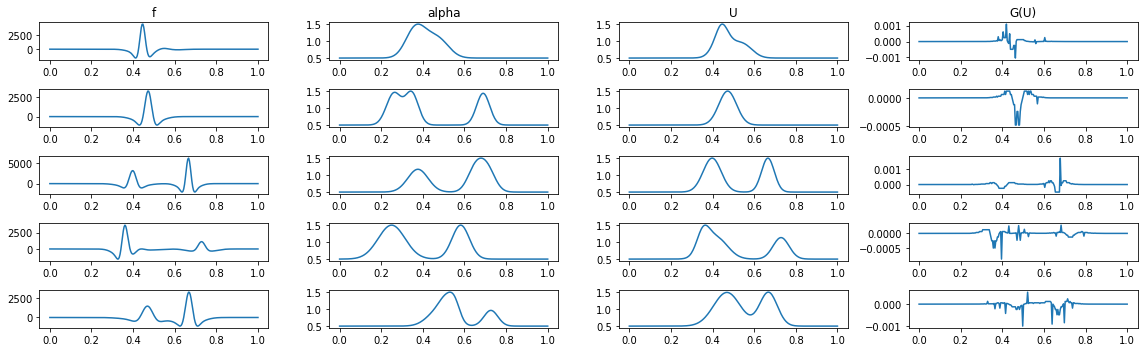

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from typing import *
import tensorflow as tf
import scipy.optimize as sco
import scipy as sci
import scipy.stats as stats
from scipy.interpolate import interp1d
import time
from matplotlib import cm
import random as rand
import tensorflow_probability as tfp
pp=print



def linspace(a,b,N,dtype):
    if dtype==tf.float32:
        return tf.linspace(a,b,N)
    elif dtype==tf.float64:
        return tf.constant(np.linspace(a,b,N))
    else:
        raise Exception("only for tf.float32 or tf.float64")


class Mesh:
  def __init__(self, N, a, b,dtype):
    self.N = N
    self.a = a
    self.b = b
    self.m = tf.linspace(tf.constant(a,dtype=dtype),tf.constant(b,dtype=dtype),N)
    self.h= tf.abs(self.m[1]-self.m[0])
    self.mid = (self.a + self.b) / 2
    self.L = self.b - self.a


  #
  # def remesh(self,N):
  #   self.N=N
  #   self.m = np.linspace(self.a,self.b,N)
  #   self.h= abs(self.m[1]-self.m[0])
  #
  # def __call__(self):
  #   return self.m


class Newton:  # à modifier /creation des jeux de données

    def __init__(self, N, a, b, k,nb_data,dtype=tf.float32,verbose=True):
        self.mesh = Mesh(N, a, b,dtype)
        self.nb_data = nb_data
        self.k = k
        self.verbose=verbose
        self.dtype=dtype

        # noinspection PyUnresolvedReferences
        self.dist = tfp.distributions.Normal(loc=tf.constant(0.,dtype=self.dtype), scale=tf.constant(1.,dtype=self.dtype) )
        #self.dist.dtype=self.dtype
        if verbose:
            print('====== Init ======')
            print('mesh size: ', self.mesh.N)
            print('mesh step: ', self.mesh.h)
            print('bc type  : ', "Neumann")


    def elliptic(self, U,alpha_loc):
        """
        alpha U + nabla(k(U) nabla(U))
        ex: k(U) = 1 + U^4
        """
        # reaction term
        reac = alpha_loc * U
        h = self.mesh.h # (N)

        Up = tf.roll(U,-1,axis=1)  #   (N)  Up = U_i+1
        Um = tf.roll(U, 1,axis=1)  #   (N)   Um = U_i-1

        # diffusion terms
        Kp = 0.5 * (self.k(U) + self.k(Up))
        Km = 0.5 * (self.k(Um) + self.k(U))

        diff = - (Kp * (Up - U) - Km * (U - Um)) / h ** 2

        diff_0 = - (Kp[:,0] * (Up[:,0] - U[:,0])) / h ** 2  # - Km * (U - Um) = uL neumann on left boundary
        diff_0=diff_0[:,None]
        diff_last = - ( - Km[:,-1] * (U[:,-1] - Um[:,-1])) / h ** 2  # - Kp * (Up - U) = uR neumann on right boundary
        diff_last=diff_last[:,None]
        diff=tf.concat([diff_0,diff[:,1:-1],diff_last],axis=1)

        return reac + diff


    def get_G_for_scipy(self,f,alpha):
        return lambda U:self.G(U,f,alpha)


    def G(self, U,f,alpha):
        """
        Cacule les résidus:
         G(U)= alpha U + nabla(k(U) nabla(U)) - f
        """
        ellip = self.elliptic(U,alpha)
        res = ellip - f
        return res


    def generate_gaussian_mix(self,nb_data):

        nb_gauss_max=6

        std = tf.random.uniform(minval=0.025, maxval=0.07,shape=[nb_gauss_max,nb_data,1],dtype=self.dtype)
        mean= tf.random.uniform(minval=self.mesh.mid - 0.25 * self.mesh.L , maxval=self.mesh.mid + 0.25 * self.mesh.L,shape=[nb_gauss_max,nb_data,1],dtype=self.dtype)
        x = (self.mesh.m[None,None,:]-mean)/std

        gauss=self.dist.prob(x)

        mask=tf.random.uniform(minval=0,maxval=1.99,shape=[nb_gauss_max,nb_data,1],dtype=self.dtype)
        mask=tf.math.floor(mask)
        gauss*=mask
        res=tf.reduce_sum(gauss,axis=0) #on somme les gaussiennes

        res = res / tf.reduce_max(res,axis=1)[:,None] + 0.5

        return res


    def generate_alpha(self,nb_data):
        return self.generate_gaussian_mix(nb_data)

    @tf.function
    def generate_XY(self):
        if self.verbose:
            print("traçage de la fonction generate_XY")
        """"""
        """
        On génére 
          u,alpha
        On en déduit le second membre
          f 
        qui permet d'avoir un résidu nul
        """
        alpha = self.generate_alpha(self.nb_data)
        U = self.generate_alpha(self.nb_data)
        f = self.elliptic(U,alpha)
        X = tf.stack([f,alpha],axis=2)
        Y = U[:,:,None]

        return X,Y


    def plot_data(self,X,Y):
        f=X[:, :, 0]
        alpha=X[:, :, 1]
        U=Y[:, :, 0]
        g=self.G(U,f,alpha)
        nb=5
        fig, ax = plt.subplots(nb, 4, figsize=(16, nb))

        for i in range(nb):
            ax[i,0].plot(self.mesh.m,f[i,:] )
            ax[i,1].plot(self.mesh.m, alpha[i,:])
            ax[i,2].plot(self.mesh.m, U[i,:] )
            ax[i,3].plot(self.mesh.m, g[i,:])
        ax[0, 0].set_title("f")
        ax[0, 1].set_title("alpha")
        ax[0, 2].set_title("U")
        ax[0, 3].set_title("G(U)")
        fig.tight_layout()






def test():
    ku2 = lambda u: u ** 4 + 1.0  # non linéarité
    #kpu2 = lambda u: 4.0 * u * u * u
    nb_data=1500
    Newton_train = Newton(N=256, a=0.0, b=1.0, k=ku2, nb_data=nb_data,dtype=tf.float32)

    #premier appel
    Newton_train.generate_XY()

    #second appel
    ti0=time.time()
    X_train,Y_train=Newton_train.generate_XY()
    duration=time.time()-ti0
    print(f"duration={duration} for nb_data={nb_data} with nb points={Newton_train.mesh.N}")

    print("X_train",X_train.shape,X_train.dtype)
    print("Y_train",Y_train.shape,X_train.dtype)

    Newton_train.plot_data(X_train,Y_train)
    plt.show()




test()



AttributeError: ignored

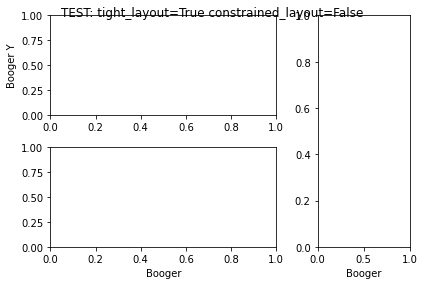

In [1]:
import matplotlib.pyplot as plt

for tl, cl in zip([True, False, False], [False, False, True]):
    fig = plt.figure(constrained_layout=cl, tight_layout=tl)

    gs = fig.add_gridspec(2, 3)

    ax = dict()

    ax['A'] = fig.add_subplot(gs[0, 0:2])
    ax['B'] = fig.add_subplot(gs[1, 0:2])
    ax['C'] = fig.add_subplot(gs[:, 2])

    ax['C'].set_xlabel('Booger')
    ax['B'].set_xlabel('Booger')
    ax['A'].set_ylabel('Booger Y')
    fig.suptitle(f'TEST: tight_layout={tl} constrained_layout={cl}')
    fig.supxlabel('XLAgg')
    fig.supylabel('YLAgg')
    
    plt.show()